<!--
---
title: "Replication of Study X by Sample & Sample (200x, Psychological Science)"
author: "Replication Author[s] (contact information)"
date: "`r format(Sys.time(), '%B %d, %Y')`"
output:
  html_document:
    toc: yes
    toc_depth: 3
    toc_float:
      collapsed: false
---
-->
# Replication of Experiment Data Analysis by Parades et. al. (submission to CHI 2020) #

## Author: Jackie Yang (jackiey@stanford.edu) ##

<!-- Replication reports should all use this template to standardize reporting across projects.  These reports will be public supplementary materials that accompany the summary report(s) of the aggregate results. -->




## Introduction

This paper is one of the first attempt at using touchpad data to predict the user's stress. This project extract muscle stiffness derived from biomechanical models of the user's movement from laptop touchpad operations while preforming predefined tasks to investigate the correlation with the user's stress. I also have a on-going project that uses deeplearning to directly infer user's stress from the trackpad data, therefore, I think it would be helpful if I can replicate their anlaysis.

Since the data collection process, which requires the physical presence of the user and expensive equipment, is quite hard to replicate, and the data analysis involves complex operations (deduct parameters from biomechanical models), I will do a replication of the data processing in this paper.

## Methods

<!--
###Power Analysis
\
Original effect size, power analysis for samples to achieve 80%, 90%, 95% power to detect that effect size.  Considerations of feasibility for selecting planned sample size.
\
###Planned Sample
\
Planned sample size and/or termination rule, sampling frame, known demographics if any, preselection rules if any.
\
###Materials
\
All materials - can quote directly from original article - just put the text in quotations and note that this was followed precisely.  Or, quote directly and just point out exceptions to what was described in the original article.
-->
### Procedure	

I will not replicate this, but this is the procedure the data is gathered in the original paper:

The experiment contained four distinct phases:
+ Relaxation phase - a five minute destressor task designed to normalize the effects of external factors and to destress the participant towards baseline levels
+ tRelaxed phase - a ten minute phase taking place immediately after the Relaxation phase. The subject performs a series of computer tasks using the laptop trackpad. Task orders within each category (clicking, dragging, steering) are fully randomized.
+ Stressor phase - a five minute stress-inducing task.
+ tStressed phase - a ten minute phase taking place immediately after the stressor phase. The subject performs a series of computer tasks using the laptop trackpad. Task orders within each category (clicking, dragging, steering) are fully randomized.
To control for order effects, subjects were assigned to one of two orders of the stressed-relaxed task pairs (see Figure 3 ). The experimental groups for each protocol were balanced by gender, with 5 males and 6 females completing each protocol.

![../figures/normal%20precedure.png](../figures/normal%20precedure.png)

![../figures/counterbalance%20precedure.png](../figures/counterbalance%20precedure.png)

### Analysis Plan

I will start from the raw data collected from each experiment, including the raw trackpad data throughout the whole experiment, and a separate file recording the division of each session in the experiment.
The trackpad file contains a time-series data with position, area of contact, the shape of contact of all the fingers in contact with the trackpad at that time.
The other file contains the start and end timestamp of each trial and the start and end timestamp of each stressed or not stressed condition.

I will perform all the data segmentation, cleaning to extract a single stream of finger events for each trial.
From the finger events, I will perform multiple different analyses as described in the paper.
Then I will compare the results of that analysis between different conditions and different experiments.
I will perform all the statistical analysis and recreate all the figures in that paper.

### Differences from Original Study

There is no known difference from the original study.

### Anticipated Challenges

The largest challenge is that I'm not familiar with those bio-mechanical models, but the programming should be within my capability.

## Links

**Repo:** https://github.com/psych251/paredes2019/

**Original Paper:** https://github.com/psych251/paredes2019/blob/wip/original_paper/paredes_2019.pdf


## Results

### Data preparation
Data preparation following the analysis plan.

Touchpad data:
+ Associate touchpad data with corresponding experiment
+ Separate the touch point-timestamp tuples into movements (list of consecutive touch point-timestamp tuples)
+ Remove very short finger movements and "static" finger movements (movements with low variation in position over time)
+ Run a low-pass filter on the movement data

Self-reported stress data:
+ Associate report data with the corresponding condition


Update 20191027: Finished most of data pre-processing

In [10]:
import pandas
from matplotlib import pyplot as plt
from replication.common import TaskType
from replication.load_data import load_data

from replication.preprocess.user import User

In [11]:
user_data = User("../original_data/data/raw_data/A2/", "A2")

In [12]:
tasks = pandas.DataFrame([vars(task) for task in user_data.stressed_condition.tasks], 
                         columns=["page_name", "task_type", "width", "height", "start", "finish"])
tasks.head()

,page_name,task_type,width,height,start,finish
0,0.html,TaskType.DRAG,512,64,1.568229e+09,1.568229e+09
1,1.html,TaskType.DRAG,512,8,1.568229e+09,1.568229e+09
2,2.html,TaskType.DRAG,256,64,1.568229e+09,1.568229e+09
3,3.html,TaskType.DRAG,1024,32,1.568229e+09,1.568229e+09
4,4.html,TaskType.DRAG,512,64,1.568229e+09,1.568229e+09


In [13]:
moves = user_data.stressed_condition.tasks[0].track_pad_df
moves.head()

,time,press,pos,x,y,x_speed,y_speed,major_axis,minor_axis,contact_area
0,1.568229e+09,4.0,12.0,-31.72,-2.03,0.00,0.12,9.88,6.99,0.867
1,1.568229e+09,4.0,2.0,-4.24,36.63,42.38,-8.50,11.41,9.06,1.062
2,1.568229e+09,4.0,12.0,-31.72,-2.03,0.38,0.00,9.98,6.99,0.871
3,1.568229e+09,4.0,2.0,-3.90,36.56,43.12,-8.75,11.42,8.96,1.062
4,1.568229e+09,4.0,12.0,-31.72,-2.03,-0.12,0.00,10.05,6.99,0.871


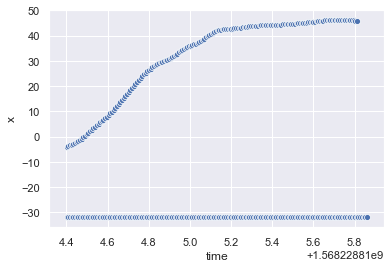

<Figure size 432x288 with 0 Axes>

In [24]:
axis = plt.gca()
user_data.stressed_condition.tasks[0].draw_moves(axis)
plt.show()
plt.clf()

### Confirmatory analysis

<!--I will run t-test on the relaxed and stressed conditions and compute Cohan's effect size (d).-->


<!--![../figures/srs.png](../figures/srs.png)-->

I will run t-test on average area for the relaxed and stressed condition and compute Cohan's effect size (d).

In [26]:
users = load_data("../original_data/data/raw_data/")

stressed_means = []
unstressed_means = []

for user in users:
    for task in user.stressed_condition.tasks:
        if task.task_type == TaskType.CLICK:
            stressed_means += [task.track_pad_df.contact_area.mean()]

    for task in user.unstressed_condition.tasks:
        if task.task_type == TaskType.CLICK:
            unstressed_means += [task.track_pad_df.contact_area.mean()]

# %%
import numpy as np

stressed_means_np = np.array(stressed_means)
unstressed_means_np = np.array(unstressed_means)

filtered_stressed_means_np = stressed_means_np[~np.isnan(stressed_means_np)]
filtered_unstressed_means_np = unstressed_means_np[~np.isnan(unstressed_means_np)] 

In [27]:
import pandas

stressed_count = len(filtered_stressed_means_np)
unstressed_count = len(filtered_unstressed_means_np)
df = pandas.DataFrame({
    'condition':
        ["stressed"] * stressed_count +
        ["unstressed"] * unstressed_count,
    'average area':
        filtered_stressed_means_np.tolist() +
        filtered_unstressed_means_np.tolist()
})

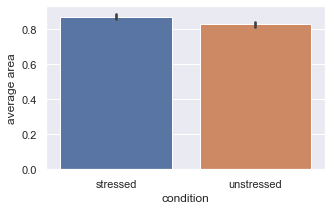

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(figsize=(5, 3))

plot = sns.barplot(x='condition', y='average area', data=df)


![../figures/aa.png](../figures/aa.png)

### Exploratory analyses

I will try to run a machine learning algorithm on the collected finger movement traces and see if I can get a stronger predictor on the user's stress.

<!--
\
### Methods Addendum (Post Data Collection)
\
You can comment this section out prior to final report with data collection.
\
#### Actual Sample
  Sample size, demographics, data exclusions based on rules spelled out in analysis plan
\
#### Differences from pre-data collection methods plan
  Any differences from what was described as the original plan, or “none”.
\
\
##Results
\
\
### Data preparation
\
Data preparation following the analysis plan.
	\
```{r include=F}
###Data Preparation
\
####Load Relevant Libraries and Functions
\
####Import data
\
#### Data exclusion / filtering
\
#### Prepare data for analysis - create columns etc.
```
\
### Confirmatory analysis
\
The analyses as specified in the analysis plan.  
\
*Side-by-side graph with original graph is ideal here*
\
###Exploratory analyses
\
Any follow-up analyses desired (not required).  
\
## Discussion
\
### Summary of Replication Attempt
\
Open the discussion section with a paragraph summarizing the primary result from the confirmatory analysis and the assessment of whether it replicated, partially replicated, or failed to replicate the original result.  
\
### Commentary
\
Add open-ended commentary (if any) reflecting (a) insights from follow-up exploratory analysis, (b) assessment of the meaning of the replication (or not) - e.g., for a failure to replicate, are the differences between original and present study ones that definitely, plausibly, or are unlikely to have been moderators of the result, and (c) discussion of any objections or challenges raised by the current and original authors about the replication attempt.  None of these need to be long.
\
-->